In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nsec.models.dae.convdae import SmallUResNet

In [3]:
import tensorflow_datasets as tfds
from jax.experimental import optix
import jax.numpy as jnp

In [4]:
import haiku as hk

In [5]:
# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [6]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.pad(train_images,((0,0),(2,2),(2,2),(0,0)))/255.

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.pad(test_images, ((0,0),(2,2),(2,2),(0,0)))/255.

In [7]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

In [8]:
batch_size=128
delta = 0.25

def get_batch():
    y = train_images[np.random.choice(len(train_images), batch_size)].astype('float32')
    u = np.random.randn(batch_size, 32,32,1)
    s = delta * np.random.randn(batch_size, 1, 1, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [38]:
optimizer = optix.adam(1e-4)
rng_seq = hk.PRNGSequence(42)
import jax 

In [39]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model.apply(params, state, rng_key, batch['x'], batch['s'], is_training=True)
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [40]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [12]:
params, state = model.init(next(rng_seq), jnp.zeros((1, 32, 32, 1)), jnp.zeros((1, 1, 1, 1)), is_training=True)
opt_state = optimizer.init(params)
losses = []

In [ ]:
for step in range(1000000):
    batch = get_batch()
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 0.056272276
100 0.060219247
200 0.05736986
300 0.06820626
400 0.05687604
500 0.053358115
600 0.054859344
700 0.061312303
800 0.06275791
900 0.058846354
1000 0.05409948
1100 0.05762884
1200 0.062066477
1300 0.057873234
1400 0.0611331
1500 0.061796352
1600 0.061746933
1700 0.060874943
1800 0.059197452
1900 0.056095205
2000 0.063911244
2100 0.056584675
2200 0.06047025
2300 0.058674853
2400 0.064652994
2500 0.05402909
2600 0.056170486
2700 0.05686991
2800 0.053981707
2900 0.062098403
3000 0.055975415
3100 0.05588302
3200 0.055575036
3300 0.061055686
3400 0.062266357
3500 0.05905803
3600 0.059822086
3700 0.05755919
3800 0.058126926
3900 0.07024918
4000 0.0605752
4100 0.058801312
4200 0.057358462
4300 0.06715756
4400 0.057542577
4500 0.060737487
4600 0.064540364
4700 0.059149753
4800 0.05664517
4900 0.059067056
5000 0.05675004
5100 0.06009906
5200 0.06136352
5300 0.060926035
5400 0.059814773
5500 0.05699147
5600 0.06426317
5700 0.05614204
5800 0.053405438
5900 0.061215013
6000 0.06516972
6

47500 0.060595516
47600 0.053331703
47700 0.063332506
47800 0.05353002
47900 0.05249141
48000 0.057897124
48100 0.054609433
48200 0.06577948
48300 0.061385125
48400 0.0530678
48500 0.056012236
48600 0.05816287
48700 0.061604377
48800 0.05249527
48900 0.060276844
49000 0.052143756
49100 0.05896321
49200 0.060264796
49300 0.062458057
49400 0.053051654
49500 0.059869353
49600 0.06938865
49700 0.056498516
49800 0.055802424
49900 0.05622764
50000 0.058979798
50100 0.06173627
50200 0.058478996
50300 0.058549006
50400 0.054513384
50500 0.055062804
50600 0.061951827
50700 0.058855567
50800 0.059712913
50900 0.054896496
51000 0.059150327
51100 0.0645362
51200 0.05310577
51300 0.055904277
51400 0.062601455
51500 0.056126203
51600 0.06250456
51700 0.061730538
51800 0.0631117
51900 0.05586867
52000 0.05653148
52100 0.061748046
52200 0.058292992
52300 0.05546059
52400 0.05917055
52500 0.056077998
52600 0.060963187
52700 0.0683165
52800 0.059485868
52900 0.055901848
53000 0.05709299
53100 0.05891137

94200 0.061233062
94300 0.054356255
94400 0.056003492
94500 0.05979565
94600 0.05383748
94700 0.05184046
94800 0.052816894
94900 0.059291065
95000 0.05964823
95100 0.056052435
95200 0.06427504
95300 0.058864
95400 0.051006943
95500 0.060387693
95600 0.054435454
95700 0.054673955
95800 0.054459766
95900 0.061024927
96000 0.056579385
96100 0.058461037
96200 0.056542665
96300 0.057114016
96400 0.057782315
96500 0.05805328
96600 0.059287574
96700 0.05693054
96800 0.05378219
96900 0.05298415
97000 0.060062286
97100 0.057160366
97200 0.058590014
97300 0.055093832
97400 0.05860122
97500 0.05695999
97600 0.05580079
97700 0.051383954
97800 0.059261825
97900 0.06265305
98000 0.058734685
98100 0.05704823
98200 0.059849486
98300 0.059152097
98400 0.05653233
98500 0.06776235
98600 0.058481358
98700 0.059772603
98800 0.05849554
98900 0.057489693
99000 0.052307084
99100 0.0554569
99200 0.054231916
99300 0.06164197
99400 0.06532998
99500 0.06225267
99600 0.05587617
99700 0.073499985
99800 0.0616248
99

138600 0.06095678
138700 0.054589976
138800 0.05559771
138900 0.05691559
139000 0.065708145
139100 0.05724593
139200 0.054990016
139300 0.063661516
139400 0.06025086
139500 0.060061637
139600 0.053914122
139700 0.059071526
139800 0.055488806
139900 0.05427491
140000 0.057565335
140100 0.055704992
140200 0.053159524
140300 0.05258
140400 0.062623814
140500 0.053292077
140600 0.0582204
140700 0.05657242
140800 0.054367863
140900 0.06015538
141000 0.06647945
141100 0.05556342
141200 0.06367774
141300 0.05952599
141400 0.062729135
141500 0.055025
141600 0.06237625
141700 0.051801052
141800 0.052179188
141900 0.056124486
142000 0.051087514
142100 0.051972408
142200 0.05112163
142300 0.06275543
142400 0.054241836
142500 0.06202241
142600 0.05460859
142700 0.056894407
142800 0.05408572
142900 0.051018383
143000 0.0562616
143100 0.059438378
143200 0.058000136
143300 0.05267901
143400 0.058731843
143500 0.05158173
143600 0.054424178
143700 0.056291018
143800 0.051411666
143900 0.05579177
144000

182900 0.05899316
183000 0.054966517
183100 0.057893496
183200 0.05299356
183300 0.052832942
183400 0.053755958
183500 0.052670043
183600 0.054362338
183700 0.053896133
183800 0.054667577
183900 0.058337193
184000 0.053181846
184100 0.054079108
184200 0.052428603
184300 0.052016698
184400 0.06783738
184500 0.057702538
184600 0.057716783
184700 0.05343805
184800 0.05569667
184900 0.057395633
185000 0.053042572
185100 0.057709858
185200 0.051284935
185300 0.059716202
185400 0.054719545
185500 0.056245968
185600 0.050506853
185700 0.054618046
185800 0.05505301
185900 0.06063462
186000 0.053095616
186100 0.060107566
186200 0.06064602
186300 0.05715145
186400 0.055313684
186500 0.05290752
186600 0.05959193
186700 0.062230203
186800 0.053928196
186900 0.06644286
187000 0.057172284
187100 0.06340358
187200 0.05192582
187300 0.05703024
187400 0.052632008
187500 0.055767346
187600 0.050227422
187700 0.057384465
187800 0.057056528
187900 0.05893415
188000 0.056013446
188100 0.053427555
188200 0.

227100 0.05847192
227200 0.05586567
227300 0.055334434
227400 0.056832764
227500 0.050713114
227600 0.048082285
227700 0.054741886
227800 0.05292505
227900 0.055767164
228000 0.06630873
228100 0.058684435
228200 0.060766816
228300 0.054801997
228400 0.058483943
228500 0.061537936
228600 0.054825865
228700 0.055946153
228800 0.054615673
228900 0.060893998
229000 0.05738348
229100 0.052831348
229200 0.05689606
229300 0.047922123
229400 0.058954008
229500 0.05415518
229600 0.055011343
229700 0.06282334
229800 0.058677174
229900 0.056554966
230000 0.06789004
230100 0.06318591
230200 0.056402143
230300 0.05273405
230400 0.059653953
230500 0.056632105
230600 0.05140988
230700 0.061985735
230800 0.053442422
230900 0.059623145
231000 0.051011637
231100 0.05695559
231200 0.05917947
231300 0.057922713
231400 0.055712596
231500 0.05496613
231600 0.06368949
231700 0.0595708
231800 0.049172174
231900 0.053558994
232000 0.052148916
232100 0.05175069
232200 0.050697226
232300 0.056084137
232400 0.053

271300 0.053868722
271400 0.054718554
271500 0.048612718
271600 0.056352403
271700 0.05355242
271800 0.056725025
271900 0.056189716
272000 0.057857085
272100 0.05128819
272200 0.05645191
272300 0.05935275
272400 0.05979279
272500 0.057772413
272600 0.059941847
272700 0.057858393
272800 0.05664404
272900 0.050032414
273000 0.059869
273100 0.04978811
273200 0.060175247
273300 0.060637053
273400 0.056566916
273500 0.05875672
273600 0.059336416
273700 0.051934212
273800 0.05820662
273900 0.052410666
274000 0.049878314
274100 0.051971197
274200 0.0603922
274300 0.051471468
274400 0.05460823
274500 0.058719914
274600 0.056348145
274700 0.057245158
274800 0.057305623
274900 0.050424498
275000 0.05744969
275100 0.05650061
275200 0.055436596
275300 0.05403079
275400 0.056260098
275500 0.049820073
275600 0.05304979
275700 0.058465965
275800 0.05429518
275900 0.0545745
276000 0.053034633
276100 0.0528849
276200 0.05147863
276300 0.054952778
276400 0.058235608
276500 0.059756044
276600 0.05641212


315600 0.05076039
315700 0.056479596
315800 0.05988295
315900 0.055370532
316000 0.05070597
316100 0.05686853
316200 0.057271034
316300 0.054244827
316400 0.052949455
316500 0.05392074
316600 0.05238089
316700 0.05369887
316800 0.05150545
316900 0.05787719
317000 0.053483848
317100 0.051178418
317200 0.054267045
317300 0.052455146
317400 0.05907294
317500 0.062947884
317600 0.05331795
317700 0.05553521
317800 0.055662036
317900 0.06317579
318000 0.053909194
318100 0.054955974
318200 0.048072573
318300 0.05595969
318400 0.05815309
318500 0.05834593
318600 0.053329587
318700 0.05354766
318800 0.053356674
318900 0.054797597
319000 0.05470004
319100 0.055857565
319200 0.053014625
319300 0.050642323
319400 0.04689132
319500 0.06559006
319600 0.052548114
319700 0.05453082
319800 0.05751241
319900 0.06263862
320000 0.056257002
320100 0.054304276
320200 0.06642109
320300 0.05516337
320400 0.052360836
320500 0.05786345
320600 0.056889135
320700 0.054769192
320800 0.04758655
320900 0.05256852
32

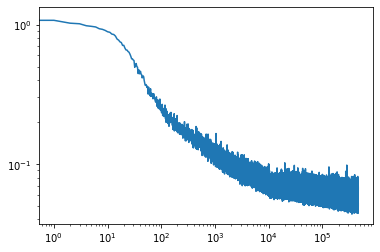

In [78]:
loglog(losses)

In [80]:
# Saving params
import pickle

# with open('conv-dae-noreg.pckl', 'wb') as file:
#     pickle.dump([params, state], file)

In [81]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [82]:
res, state = score(batch['x'],batch['s'], is_training=False)

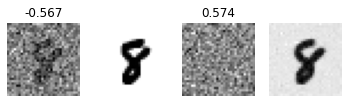

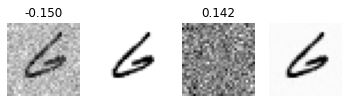

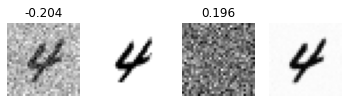

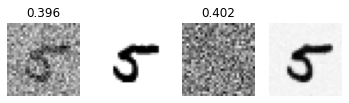

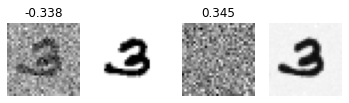

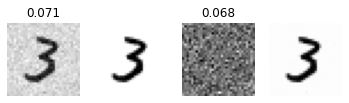

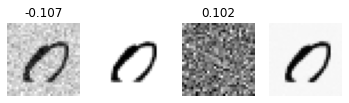

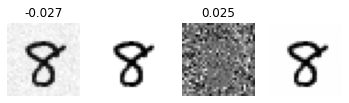

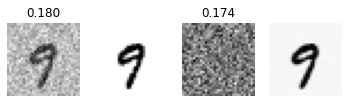

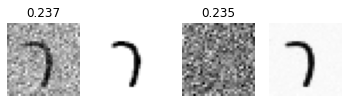

In [83]:
for i in range(10):
  ind = i
  figure()
  subplot(141)
  title("%0.3f"%batch['s'][ind,0,0,0])
  imshow(batch['x'][ind,...,0],cmap='gray_r')
  axis('off')
  subplot(142)
  imshow(batch['y'][ind,...,0],cmap='gray_r')
  axis('off')
  subplot(143)
  imshow(res[ind,...,0],cmap='gray_r')
  axis('off')
  title("%0.3f"%std(batch['s'][ind,:,:,0]**2 *res[ind,...,0]))
  subplot(144)
  imshow(batch['x'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='gray_r')
  axis('off')

In [84]:
# Trying to sample from the model
from nsec.samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm

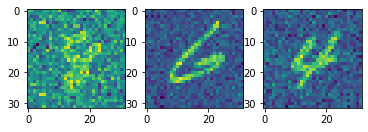

In [85]:
subplot(131)
imshow(batch['x'][0,...,0].reshape((32,32,)))
subplot(132)
imshow(batch['x'][1,...,0].reshape((32,32,)))
subplot(133)
imshow(batch['x'][2,...,0].reshape((32,32,)))

In [86]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

def score_fn(x):
    return score(x.reshape((1,32,32,1)), jnp.zeros((1,1,1,1))+1e-2, is_training=False)[0].reshape((32*32,))

In [87]:
num_results = int(1e4)
num_burnin_steps = int(1e1)

In [88]:
@jax.jit
def get_samples():
    # First running SHMC
    kernel_shmc = ScoreHamiltonianMonteCarlo(
            target_score_fn=score_fn,
            num_leapfrog_steps=4,
            num_delta_logp_steps=4,
            step_size=0.003)
 
    samples_shmc, is_accepted_shmc = tfp.mcmc.sample_chain(
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          current_state= batch['x'][0,...,0].reshape((32*32,)),#0.5*randn(32,32).reshape((32*32,)).astype('float32'),#
          kernel=kernel_shmc,
          trace_fn=lambda _, pkr: pkr.is_accepted, 
          seed=jax.random.PRNGKey(1))
    return samples_shmc, is_accepted_shmc 
 
samples_shmc, is_accepted_shmc = get_samples()

In [89]:
len(where(is_accepted_shmc)[0])

5913

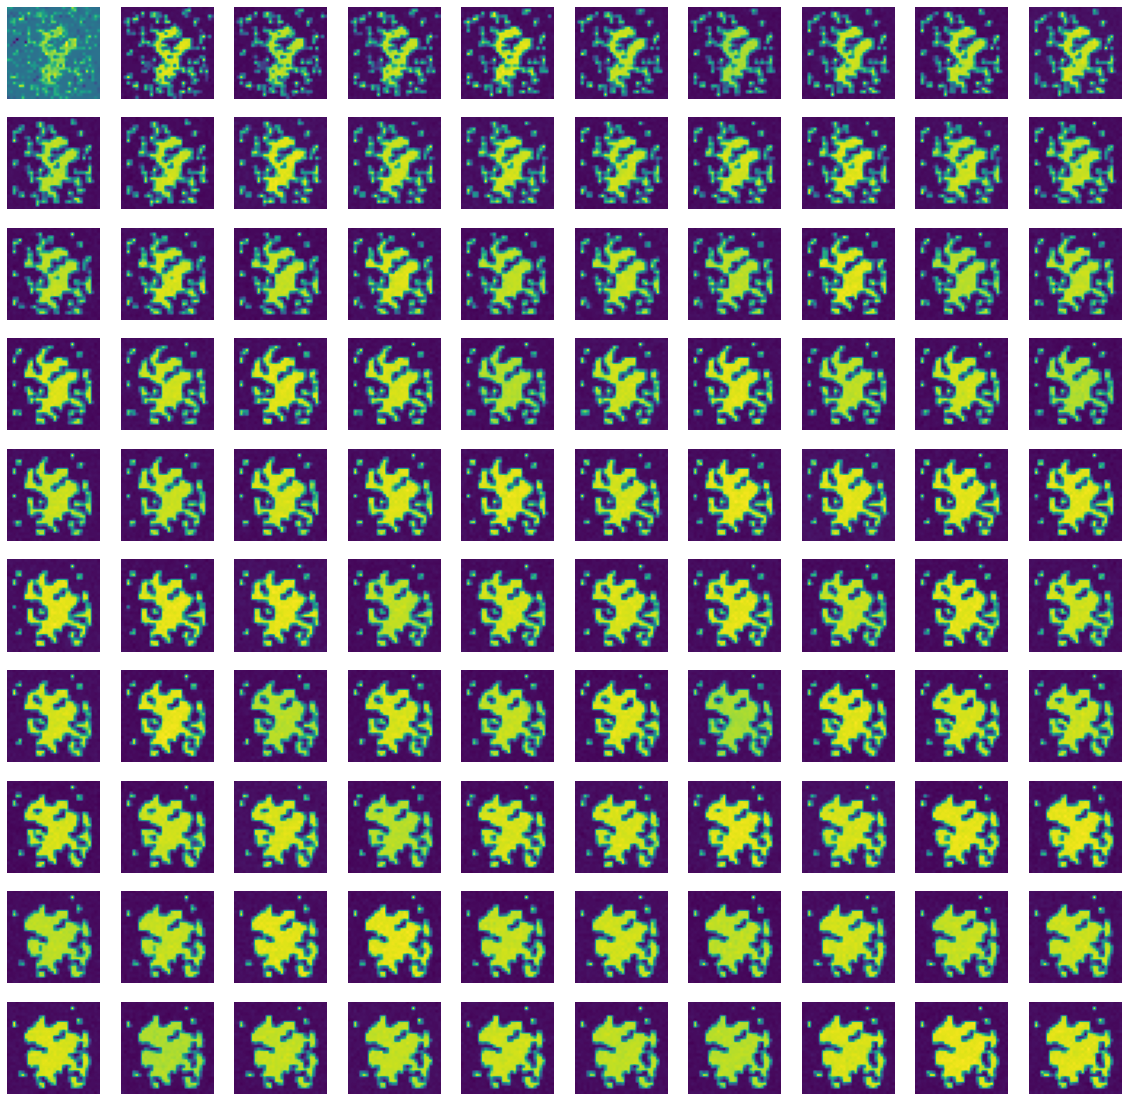

In [90]:
# This is with sampling noise of 1e-2 after a ton of more training
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

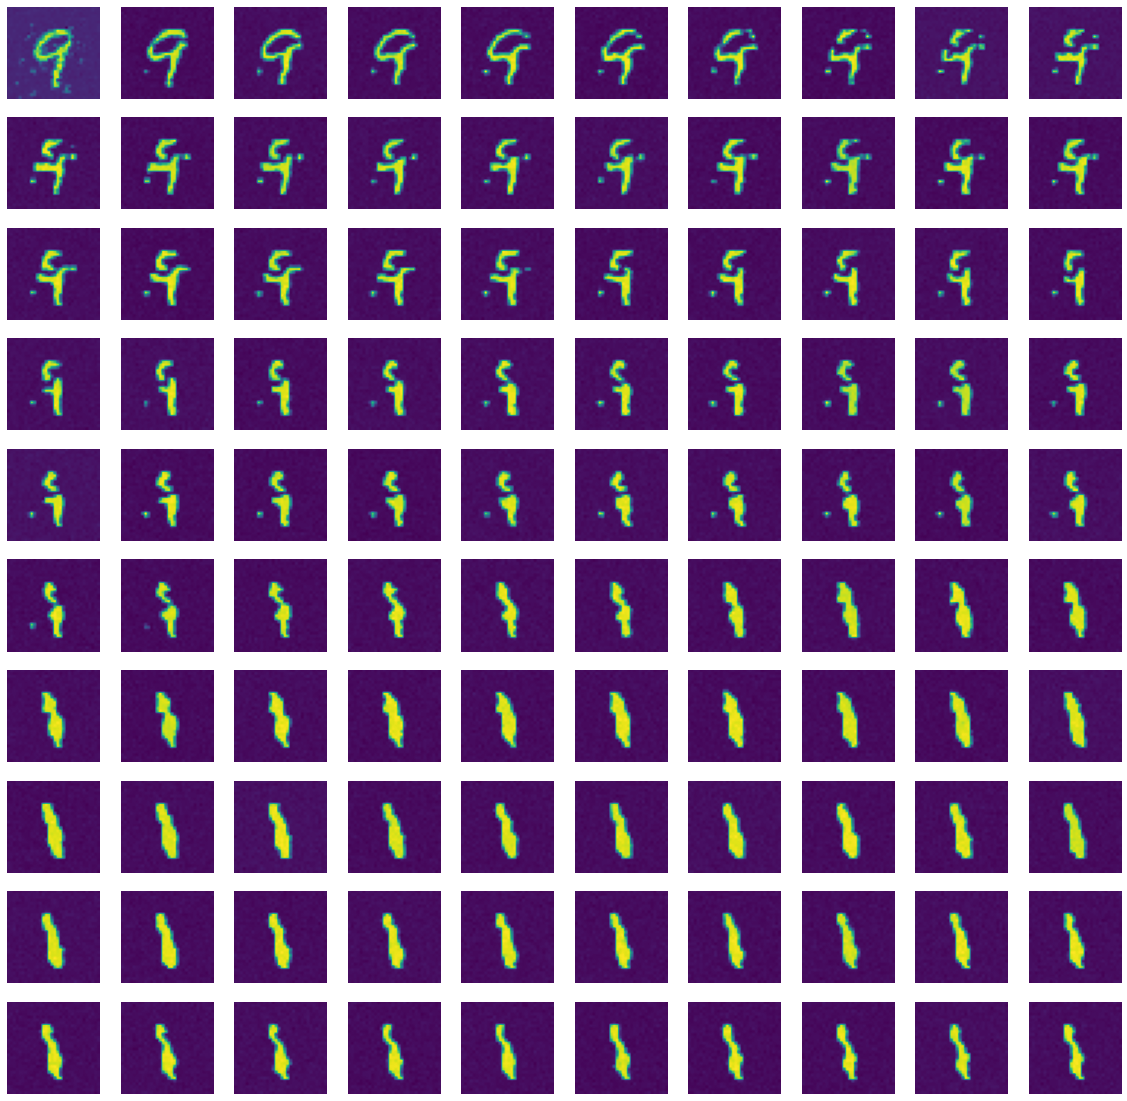

In [76]:
# This is with sampling noise of 1e-2
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*1000].reshape((32,32)))
    axis('off')

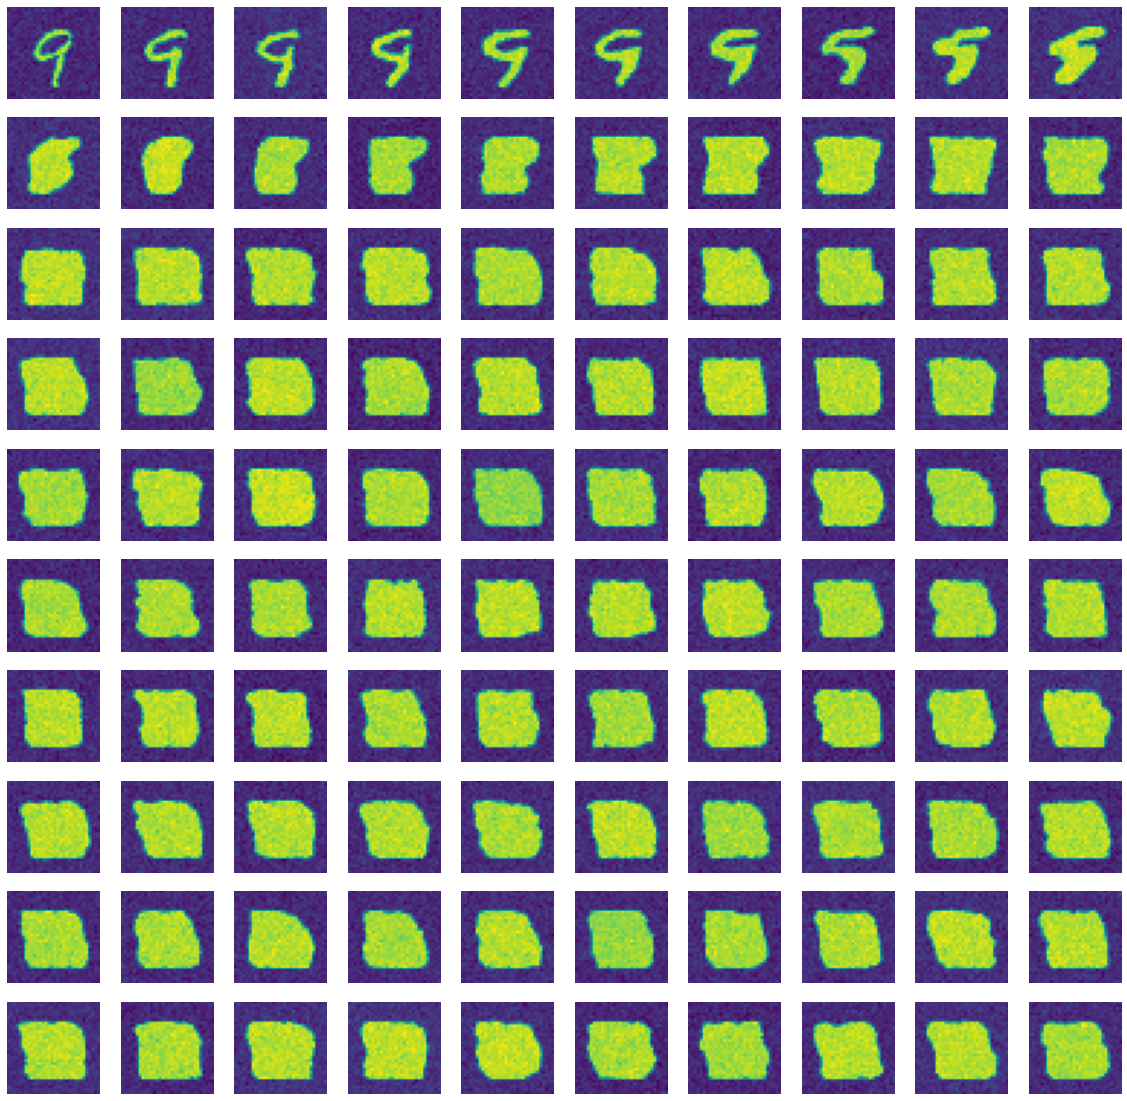

In [57]:
# This is after a further 100000 iterations at 1e-4
# here sigma noise level was 5e-2
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*1000].reshape((32,32)))
    axis('off')

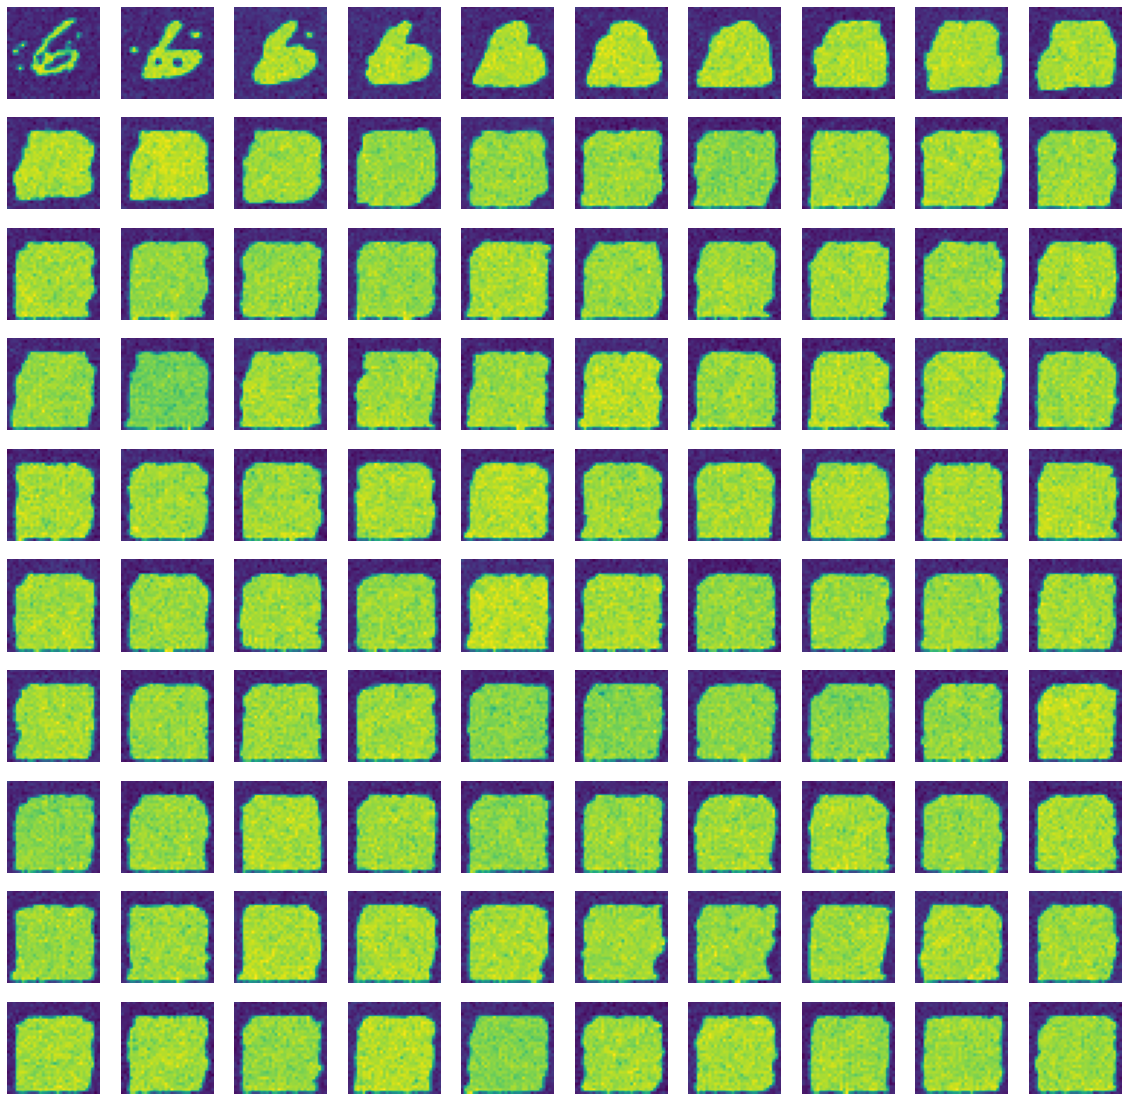

In [37]:
# This is after the first round of training at 1e-3 for 10000
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*1000].reshape((32,32)))
    axis('off')

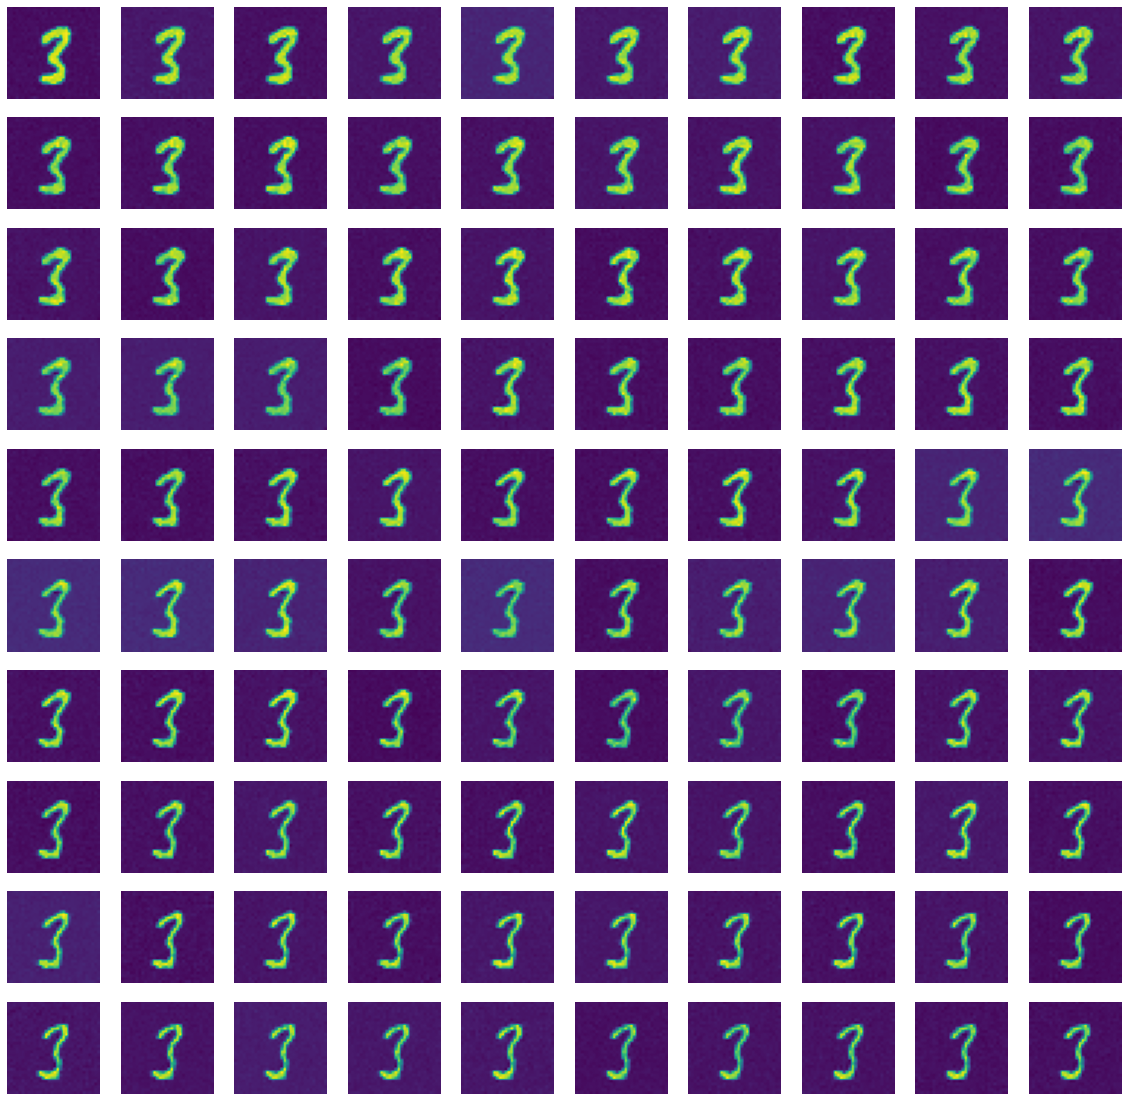

In [39]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')

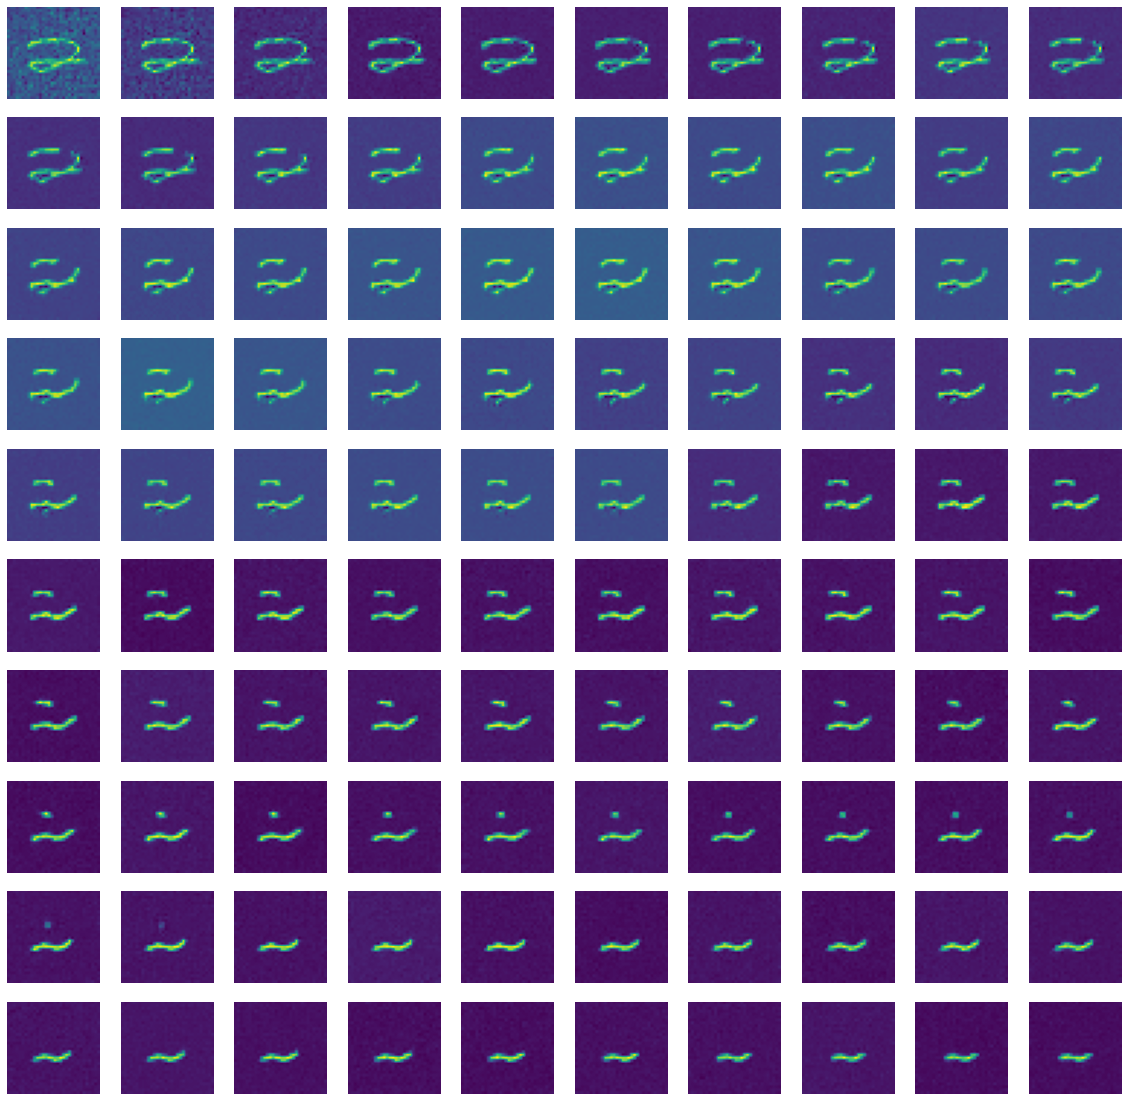

In [30]:
figure(figsize=(20,20))
for i in range(10):
  for j in range(10):
    subplot(10,10,10*i+j+1)
    imshow(samples_shmc[(10*i+j)*100].reshape((32,32)))
    axis('off')